# Hindcast verification
This Notebook evaluates the performance of ensemble hindcasts using deterministic and probabilistic verification metrics that capture various attributes of the forecasts (e.g., accuracy, skill, reliability, etc.). To get a complete understanding of the quality of a forecast, several different verification metrics can be calculated that aim to capture one or multiple of these attributes. For more info see this [forecast verification documentation](https://www.cawcr.gov.au/projects/verification/).

Throughout this Notebook, target period refers to the period of time that is being predicted (e.g., the flow accumulation between January and September) and start date/initialization date refers to the time when the forecast was issued (e.g., the 1st of January).

Decisions:
- We run the evaluation with bootstrapping to quantify uncertainty in the results' and perform 100 iterations (see user-specified variables below).
- We require a minimum of 10 observation-hindcast pairs to calculate the various metrics (see user-specified variables below).
- For the ROC, we calculate results for low flows (flows below the lower tercile of climatology) & high flows (flows above the upper tercile of climatology). Both thresholds are defined in user-specified variables but the signs are hardcoded in the relevant functions.
- We calculate the ROC using 0.1 bins (i.e., 0-0.1, 0.1-0.2, ..., 0.9-1). See user-specified variables below.
- We use the ensemble hindcast medians to calculate deterministic metrics.
- The observations climatology is used as baseline for skill calculations.

The "Variables" section below is the only section a user will need to modify for testing different options for most of these decisions.

## Modules, settings & functions

In [1]:
# Import required modules
import logging
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import os
from pprint import pprint
import sys
import xarray as xr

In [2]:
# Add scripts to the system path
sys.path.append('../scripts')

# Set up logging, configured for this workflow (see utilities.py)
from utilities import setup_logging, read_settings
setup_logging()

# Set up logging for this notebook
logger = logging.getLogger()

# Suppress misc. comments from being added to the log file
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

# Get the logger for fiona._env and suppress everything below CRITICAL level
fiona_env_logger = logging.getLogger('fiona._env')
fiona_env_logger.setLevel(logging.CRITICAL)

%load_ext autoreload
%autoreload 2

2024-10-10 11:21:33,178 - root - INFO - Logging setup complete. Log file: C:\Users\lauri\PycharmProjects\FROSTBYTE\logs\data_driven_forecasting_20241010_112133.log


In [3]:
# Save Notebook name to the log file
logger.debug(f'Notebook: 5_HindcastVerification')

In [4]:
# Read settings file
settings = read_settings('../settings/config_test_case.yaml', log_settings=True)
pprint(settings)

2024-10-10 11:21:33,363 - root - INFO - Settings logged from ../settings/config_test_case.yaml


{'SWE_obs_path': '../test_case_data/input_data/SWE_1979_2022_testcases.nc',
 'basins_dem_path': '../test_case_data/input_data/MERIT_Hydro_dem_',
 'basins_shp_path': '../test_case_data/input_data/basins_testcases.shp',
 'domain': '05BB001',
 'output_data_path': '../test_case_data/output_data/',
 'plots_path': '../test_case_data/output_plots/',
 'precip_obs_path': '../test_case_data/input_data/SCDNA_v1.1_testcases.nc',
 'streamflow_obs_path': '../test_case_data/input_data/Qobs_1979_2021_testcases.nc'}


In [5]:
# Import required functions
from functions import det_metrics_calculation, prob_metrics_calculation

## Variables

In [6]:
# Set user-specified variables
test_basin_id = settings['domain'] # Can override this with testbasin_id = <string of the testbasin id>, make sure that this id is in the input data files
niterations_default = 100 # number of iterations for bootstrapping
min_obs_default = 10 # the minimum number of observation-hindcast pairs required to calculate the various metrics
perc_event_low_default, perc_event_high_default = .33, .66  # low and high flow percentiles to use for the ROC calculations
bins_thresholds_default = np.arange(0,1.1,.1) # set of increasing probability thresholds to make the yes/no decision for the ROC calculations

In [7]:
# Save the user-specified variables to the log file
logger.debug(f'test basin ID: {test_basin_id}')
logger.debug(f'number of bootstrapping iterations for evaluation metrics calculation: {niterations_default}')
logger.debug(f'min. number of observations-hindcasts for forecast evaluation: {min_obs_default}')
logger.debug(f'climatology percentile used as low flow threshold for the ROC calculation: {perc_event_low_default}')
logger.debug(f'climatology percentile used as high flow threshold for the ROC calculation: {perc_event_high_default}')
logger.debug(f'bins for the ROC calculation: {bins_thresholds_default}')

## Read data

In [8]:
# Read observation data
obs_ds = xr.open_dataset(settings['output_data_path']+"Vol_1979_2021_basin"+test_basin_id+".nc").sel(Station_ID = test_basin_id)

display(obs_ds)

<xarray.Dataset>
Dimensions:         (year: 43)
Coordinates:
    lat             float64 ...
    lon             float64 ...
    source          object ...
    Station_ID      <U7 '05BB001'
  * year            (year) int64 1979 1980 1981 1982 ... 2018 2019 2020 2021
Data variables:
    Vol_1Jan-30Sep  (year) float64 ...
    Vol_1Feb-30Sep  (year) float64 ...
    Vol_1Mar-30Sep  (year) float64 ...
    Vol_1Apr-30Sep  (year) float64 ...
    Vol_1May-30Sep  (year) float64 ...
    Vol_1Jun-30Sep  (year) float64 ...
    Vol_1Jul-30Sep  (year) float64 ...
    Vol_1Aug-30Sep  (year) float64 ...
    Vol_1Sep-30Sep  (year) float64 ...

In [9]:
# Read ensemble hindcast data
ens_fc_ds = xr.open_dataset(settings['output_data_path']+"ensemble_hindcasts_basin"+test_basin_id+".nc")

display(ens_fc_ds)

<xarray.Dataset>
Dimensions:         (ens_member: 100, init_date: 9, year: 41)
Coordinates:
  * init_date       (init_date) object '01/01' '01/02' ... '01/08' '01/09'
  * year            (year) int64 1979 1980 1981 1982 ... 2016 2018 2019 2020
  * ens_member      (ens_member) int64 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
Data variables:
    Vol_1Jan-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Feb-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Mar-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Apr-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1May-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Jun-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Jul-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Aug-30Sep  (year, ens_member, init_date) float64 ...
    Vol_1Sep-30Sep  (year, ens_member, init_date) float64 ...

## Calculate deterministic hindcast verification metrics

In [10]:
# Calculate deterministic verification metrics with bootstrapping (flag=1)
rsquared_bs_da, KGE_bs_da, KGE_r_bs_da, KGE_alpha_bs_da, KGE_beta_bs_da, perc_diff_bs_da = det_metrics_calculation(Qobs=obs_ds, Qfc_det=ens_fc_ds.median(dim='ens_member'), flag=1, niterations=niterations_default, min_obs=min_obs_default)

In [11]:
# Save into a single xarray DataSet
det_verif_metrics_bs_basin_ds = xr.merge([rsquared_bs_da, KGE_bs_da, KGE_r_bs_da, KGE_alpha_bs_da, KGE_beta_bs_da, perc_diff_bs_da])
det_verif_metrics_bs_basin_ds.attrs['info'] = 'Various deterministic verification metrics calculated for basin '+test_basin_id+'.'

display(det_verif_metrics_bs_basin_ds)

<xarray.Dataset>
Dimensions:        (init_date: 9, iteration: 100, target_period: 9)
Coordinates:
  * init_date      (init_date) object '01/01' '01/02' ... '01/08' '01/09'
  * target_period  (target_period) <U10 '1Jan-30Sep' ... '1Sep-30Sep'
  * iteration      (iteration) int32 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
Data variables:
    R2             (init_date, target_period, iteration) float64 0.32 ... nan
    KGE"           (init_date, target_period, iteration) float64 0.46 ... nan
    KGE"_r         (init_date, target_period, iteration) float64 0.57 ... nan
    KGE"_alpha     (init_date, target_period, iteration) float64 0.68 ... nan
    KGE"_beta      (init_date, target_period, iteration) float64 -0.02 ... nan
    perc_diff      (init_date, target_period, iteration) float64 0.58 ... nan
Attributes:
    info:     Various deterministic verification metrics calculated for basin...

We'll now make a few plots to visualize the deterministic quality of the hindcasts. These are just a few example plots and it is not meant to provide a complete overview.

<IPython.core.display.Javascript object>


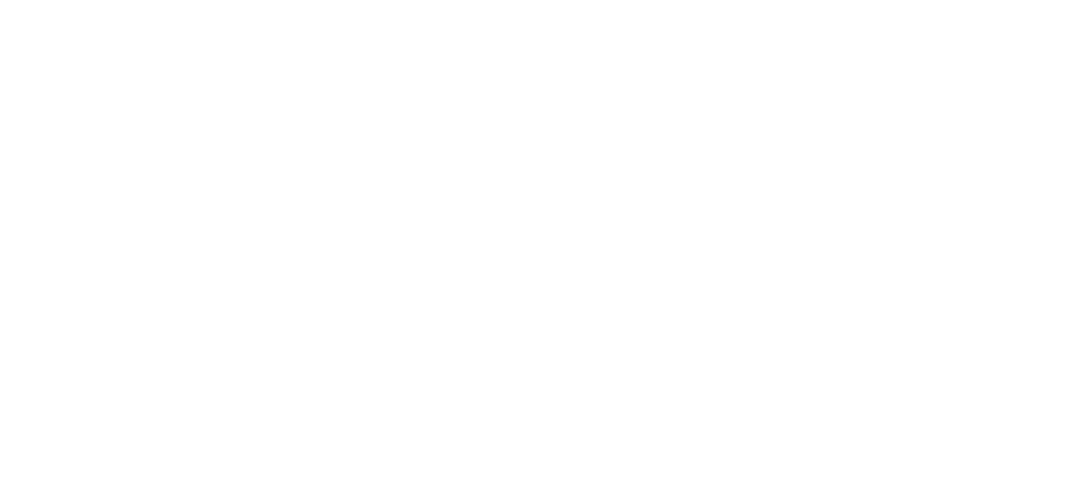

In [12]:
# Plot the KGE" (bootstrapping mean) for each target period as a function of initialization dates

# Initialize some elements
fig = plt.figure(figsize=(9,4))
elem = -1
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = det_verif_metrics_bs_basin_ds.target_period.values
init_dates = det_verif_metrics_bs_basin_ds.init_date.values

# Loop over the target periods to plot
for t in target_periods:

    elem += 1
    rgba = cmap((1*elem)/len(target_periods))
    rgbas.append(rgba)
    
    toplot = KGE_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    plt.plot(np.arange(len(toplot.init_date)), toplot.values, marker='o', color=rgba, alpha=.8, label=t)

# Add elements to the plot
plt.ylim(-1.05,1.05)
plt.xlim(-.7,len(target_periods)-.3)
plt.plot([-.7,len(target_periods)-.3],[-.41,-.41],color='grey',ls='--',zorder=1)
plt.annotate('lower benchmark', (len(target_periods)-1.8,-.5), color='grey', fontsize=8)
plt.plot([-.7,len(target_periods)-.3],[1,1],color='grey',ls='--',zorder=1)
plt.annotate('perfect score', (len(target_periods)-1.45,.9), color='grey', fontsize=8)
plt.xticks(np.arange(0,len(target_periods)), init_dates)
plt.xlabel('Initialization dates')
plt.ylabel('KGE"')
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.25,.5))
plt.tight_layout();

This plot shows the hindcast performance (in terms of the KGE") for different target periods and initialization dates. The KGE" ranges between -∞ and 1, with a perfect score of 1. [Knoben et al., 2019](https://doi.org/10.5194/hess-23-4323-2019) defined a lower threshold of KGE=-0.41, above which simulations improve upon the mean flow benchmark; this still holds for the KGE". For the Bow River at Banff, the KGE" increases slightly with increasing initialization dates up to hindcasts initialized on the 1st of June. We can also see that earlier target periods have higher KGE" compared to later ones.

In [13]:
# Save the figure
fig.savefig(settings['plots_path']+'KGE"_basin'+test_basin_id+'.png', dpi=300)

OSError: [Errno 22] Invalid argument: '../test_case_data/output_plots/KGE"_basin05BB001.png'

In [14]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

Let's add some confidence intervals to this plot.

<IPython.core.display.Javascript object>


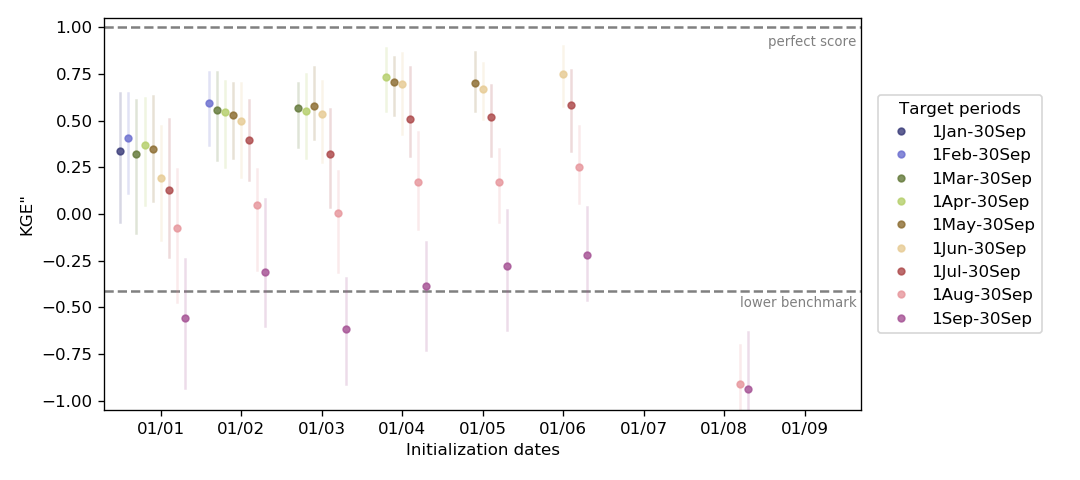

In [15]:
# Plot the KGE" with confidence intervals for each target period as a function of initialization dates

# Initialize some elements
fig = plt.figure(figsize=(9,4))
elem = -1
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = det_verif_metrics_bs_basin_ds.target_period.values
init_dates = det_verif_metrics_bs_basin_ds.init_date.values
offsets = [-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3]

# Loop over the target periods to plot
for t in target_periods:

    elem += 1
    rgba = cmap((1*elem)/len(target_periods))
    rgbas.append(rgba)
    
    toplot = KGE_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    plt.plot(np.arange(len(toplot.init_date))+offsets[elem], toplot.values, marker='o', color=rgba, alpha=.8, label=t, lw=0, ms=4)
    
    min_toplot = KGE_bs_da.sel(target_period=t).min(dim='iteration', skipna=False)
    max_toplot = KGE_bs_da.sel(target_period=t).max(dim='iteration', skipna=False)
    for i in range(len(min_toplot.init_date)):
        plt.plot([i+offsets[elem],i+offsets[elem]],[min_toplot.values[i], max_toplot.values[i]], color=rgba, alpha=.2)

# Add elements to the plot
plt.ylim(-1.05,1.05)
plt.xlim(-.7,len(target_periods)-.3)
plt.plot([-.7,len(target_periods)-.3],[-.41,-.41],color='grey',ls='--',zorder=1)
plt.annotate('lower benchmark', (len(target_periods)-1.8,-.5), color='grey', fontsize=8)
plt.plot([-.7,len(target_periods)-.3],[1,1],color='grey',ls='--',zorder=1)
plt.annotate('perfect score', (len(target_periods)-1.45,.9), color='grey', fontsize=8)
plt.xticks(np.arange(0,len(target_periods)), init_dates)
plt.xlabel('Initialization dates')
plt.ylabel('KGE"')
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.25,.5))
plt.tight_layout();

The bars show the confidence intervals (i.e., the min and max values from bootstrapping iterations).

In [16]:
# Save the figure
fig.savefig(settings['plots_path']+'KGE"_confidence_intervals_basin'+test_basin_id+'.png', dpi=300)

OSError: [Errno 22] Invalid argument: '../test_case_data/output_plots/KGE"_confidence_intervals_basin05BB001.png'

In [17]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


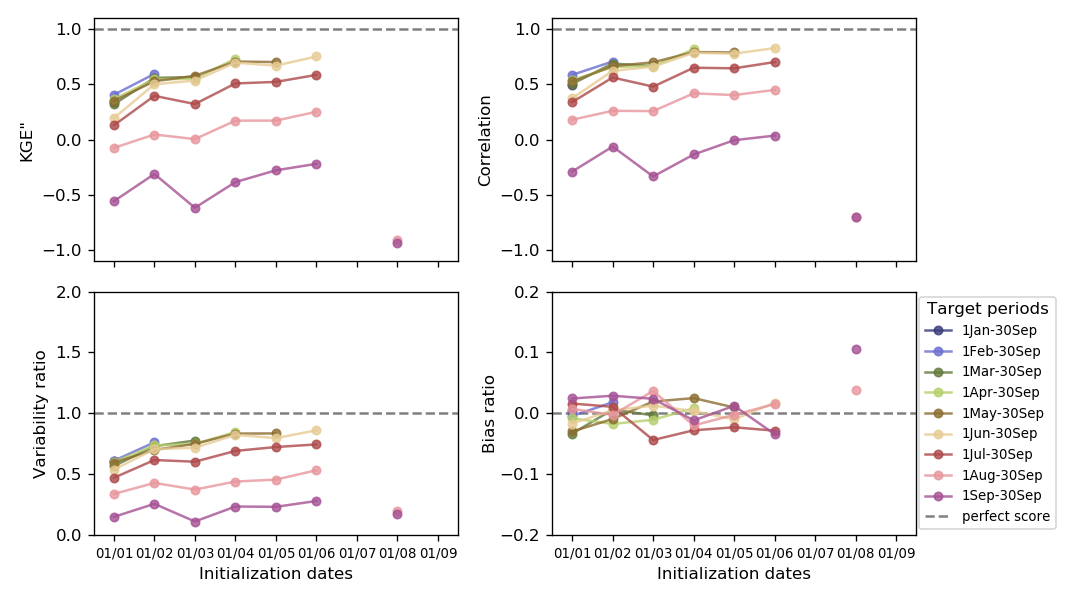

In [18]:
# Plot the KGE" and its decomposition

# Initialize some elements
fig, axes = plt.subplots(2,2,figsize=(9,5))
elem = -1
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = det_verif_metrics_bs_basin_ds.target_period.values
init_dates = det_verif_metrics_bs_basin_ds.init_date.values

# Loop over the target periods to plot
for t in target_periods:

    elem += 1
    rgba = cmap((1*elem)/len(target_periods))
    rgbas.append(rgba)
    
    # KGE subplot
    toplot = KGE_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    axes[0,0].plot(np.arange(len(toplot.init_date)), toplot.values, marker='o', color=rgba, alpha=.8, markersize=5)
    
    # correlation subplot
    toplot = KGE_r_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    axes[0,1].plot(np.arange(len(toplot.init_date)), toplot.values, marker='o', color=rgba, alpha=.8, markersize=5)
    
    # variability ratio subplot
    toplot = KGE_alpha_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    axes[1,0].plot(np.arange(len(toplot.init_date)), toplot.values, marker='o', color=rgba, alpha=.8, markersize=5)
    
    # bias ratio subplot
    toplot = KGE_beta_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    axes[1,1].plot(np.arange(len(toplot.init_date)), toplot.values, marker='o', color=rgba, alpha=.8, markersize=5, label=t)
    

# Add elements to the plot

# KGE subplot
axes[0,0].set_ylim(-1.1,1.1)
axes[0,0].set_xlim(-.5,len(init_dates)-.5)
axes[0,0].plot([-.5,len(init_dates)-.5],[1,1],color='grey',ls='--', zorder=1)
axes[0,0].set_xticks(np.arange(0,len(init_dates)))
axes[0,0].set_xticklabels([])
axes[0,0].set_ylabel('KGE"')

# correlation subplot
axes[0,1].set_ylim(-1.1,1.1)
axes[0,1].set_xlim(-.5,len(init_dates)-.5)
axes[0,1].plot([-.5,len(init_dates)-.5],[1,1],color='grey',ls='--', zorder=1)
axes[0,1].set_xticks(np.arange(0,len(init_dates)))
axes[0,1].set_xticklabels([])
axes[0,1].set_ylabel('Correlation')

# variability ratio subplot
axes[1,0].set_ylim(0,2)
axes[1,0].set_xlim(-.5,len(init_dates)-.5)
axes[1,0].plot([-.5,len(init_dates)-.5],[1,1],color='grey',ls='--', zorder=1)
axes[1,0].set_xticks(np.arange(0,len(init_dates)))
axes[1,0].set_xticklabels(init_dates, fontsize=8)
axes[1,0].set_ylabel('Variability ratio')
axes[1,0].set_xlabel('Initialization dates')

# bias ratio subplot
axes[1,1].set_ylim(-.2,.2)
axes[1,1].set_xlim(-.5,len(init_dates)-.5)
axes[1,1].plot([-.5,len(init_dates)-.5],[0,0],color='grey',ls='--', zorder=1, label='perfect score')
plt.xticks(np.arange(0,len(init_dates)), init_dates, fontsize=8)
plt.ylabel('Bias ratio', labelpad=1)
plt.xlabel('Initialization dates')

plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.4,.5), fontsize=8)
plt.tight_layout();

This plot shows a decomposition of the KGE" (i.e., correlation, bias, and variability) for different target periods and initialization dates. The same pattern as the KGE" can be observed for the correlation and variability. That pattern is more nuanced for the variability ratio. The variability tends to be underestimated (<1). The bias ratio oscillates around the 0 line, indicating that the hindcast medians overall overestimate or underestimate the observed volumes, depending on the initialization date and target period. Biases appear slighly higher for hindcasts initialized on the 1st of January.

In [19]:
# Save the figure
fig.savefig(settings['plots_path']+'KGE"_decomposition_basin'+test_basin_id+'.png', dpi=300)

OSError: [Errno 22] Invalid argument: '../test_case_data/output_plots/KGE"_decomposition_basin05BB001.png'

In [20]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Calculate probabilistic hindcast verification metrics

In [21]:
# Calculate probabilistic verification metrics with bootstrapping (flag=1)
# Note: this takes a little while to run for all the bootstrapping iterations
crpss_bs_da, fair_crpss_bs_da, reli_bs_da, roc_auc_bs_da, roc_bs_da = prob_metrics_calculation(Qobs=obs_ds, Qfc_ens=ens_fc_ds, flag=1, niterations=niterations_default, perc_event_low=perc_event_low_default, perc_event_high=perc_event_high_default, min_obs=min_obs_default, bins_thresholds=bins_thresholds_default)

In [22]:
# Save into a single xarray DataFrame
prob_verif_metrics_bs_basin_ds = xr.merge([crpss_bs_da, fair_crpss_bs_da, reli_bs_da, roc_auc_bs_da, roc_bs_da])
prob_verif_metrics_bs_basin_ds.attrs['info'] = 'Various probabilistic verification metrics calculated for basin '+test_basin_id+'.'

display(prob_verif_metrics_bs_basin_ds)

<xarray.Dataset>
Dimensions:            (bins: 11, event: 2, init_date: 9, iteration: 100, rate: 2, target_period: 9)
Coordinates:
  * init_date          (init_date) object '01/01' '01/02' ... '01/08' '01/09'
  * target_period      (target_period) <U10 '1Jan-30Sep' ... '1Sep-30Sep'
  * iteration          (iteration) int32 1 2 3 4 5 6 7 ... 94 95 96 97 98 99 100
  * event              (event) float64 0.33 0.66
  * rate               (rate) <U3 'FAR' 'HR'
  * bins               (bins) float64 0.0 0.1 0.2 0.3 0.4 ... 0.7 0.8 0.9 1.0
Data variables:
    CRPSS              (init_date, target_period, iteration) float64 0.06 ... nan
    fairCRPSS          (init_date, target_period, iteration) float64 0.66 ... nan
    Reliability_index  (init_date, target_period, iteration) float64 0.89 ... nan
    ROC_AUC            (init_date, target_period, iteration, event) float64 0.49 ... nan
    ROC                (init_date, target_period, iteration, rate, bins, event) float64 1.0 ... nan
Attributes:
    info:     Various probabilistic verification metrics calculated for basin...

We'll now make a few plots to visualize the probabilistic quality of the hindcasts. Again, these are just a few example plots.

<IPython.core.display.Javascript object>


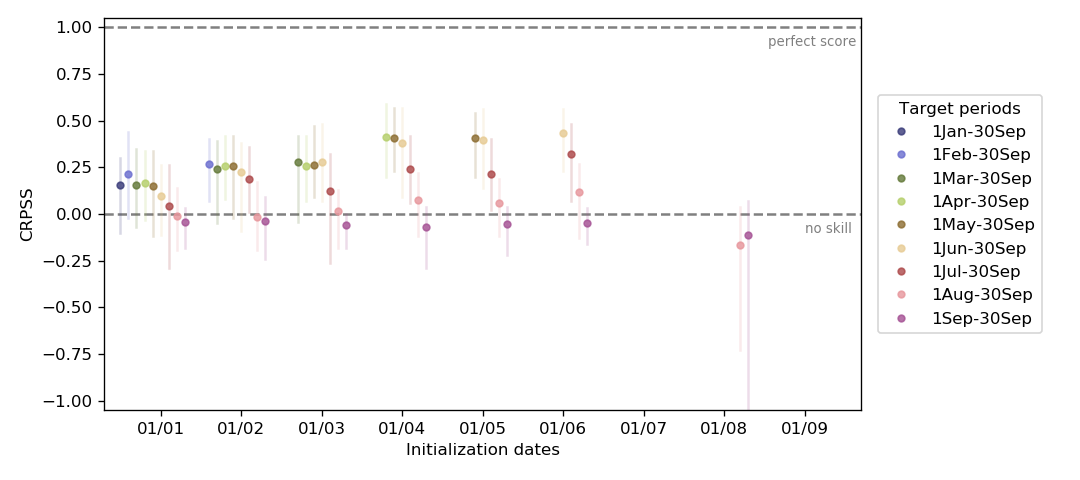

In [23]:
# Plot the CRPSS with confidence intervals for each target period as a function of initialization dates

# Initialize some elements
fig = plt.figure(figsize=(9,4))
elem = -1
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = prob_verif_metrics_bs_basin_ds.target_period.values
init_dates = prob_verif_metrics_bs_basin_ds.init_date.values
offsets = [-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3]

# Loop over the target periods to plot
for t in target_periods:

    elem += 1
    rgba = cmap((1*elem)/len(target_periods))
    rgbas.append(rgba)
    
    toplot = crpss_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    plt.plot(np.arange(len(toplot.init_date))+offsets[elem], toplot.values, marker='o', color=rgba, alpha=.8, label=t, lw=0, ms=4)
    
    min_toplot = crpss_bs_da.sel(target_period=t).min(dim='iteration', skipna=False)
    max_toplot = crpss_bs_da.sel(target_period=t).max(dim='iteration', skipna=False)
    for i in range(len(min_toplot.init_date)):
        plt.plot([i+offsets[elem],i+offsets[elem]],[min_toplot.values[i], max_toplot.values[i]], color=rgba, alpha=.2)

# Add elements to the plot
plt.ylim(-1.05,1.05)
plt.xlim(-.7,len(target_periods)-.3)
plt.plot([-.7,len(target_periods)-.3],[0,0],color='grey',ls='--',zorder=1)
plt.annotate('no skill', (len(target_periods)-1,-.1), color='grey', fontsize=8)
plt.plot([-.7,len(target_periods)-.3],[1,1],color='grey',ls='--',zorder=1)
plt.annotate('perfect score', (len(target_periods)-1.45,.9), color='grey', fontsize=8)
plt.xticks(np.arange(0,len(target_periods)), init_dates)
plt.xlabel('Initialization dates')
plt.ylabel('CRPSS')
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.25,.5))
plt.tight_layout();

This plot shows the hindcast skill (in terms of the CRPSS) for different target periods and initialization dates. The CRPSS ranges between -∞ and 1, with a perfect score of 1. CRPSS=0 represents the threshold below which hindcasts have no skill compared to the baseline (i.e., observed climatology). For the Bow River at Banff, we can observe a similar pattern to the KGE" plot. Overall, hindcasts appear skillful for target periods 1Jan-30Sep up to and including 1Jul-30Sep.

In [24]:
# Save the figure
fig.savefig(settings['plots_path']+"CRPSS_confidence_intervals_basin"+test_basin_id+".png", dpi=300)

In [25]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


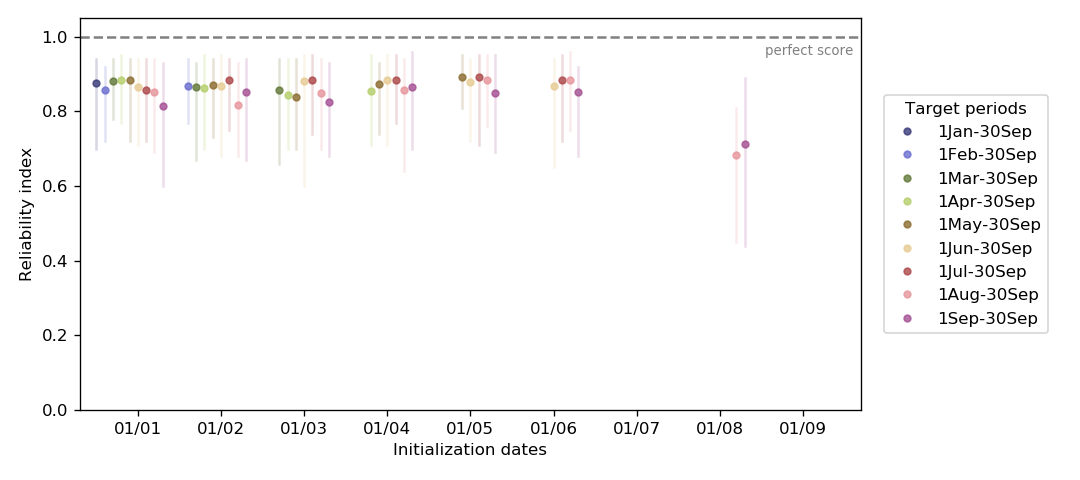

In [26]:
# Plot the reliability index with confidence intervals for each target period as a function of initialization dates

# Initialize some elements
fig = plt.figure(figsize=(9,4))
elem = -1
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = prob_verif_metrics_bs_basin_ds.target_period.values
init_dates = prob_verif_metrics_bs_basin_ds.init_date.values
offsets = [-.5,-.4,-.3,-.2,-.1,0,.1,.2,.3]

# Loop over the target periods to plot
for t in target_periods:

    elem += 1
    rgba = cmap((1*elem)/len(target_periods))
    rgbas.append(rgba)
    
    toplot = reli_bs_da.sel(target_period=t).mean(dim='iteration', skipna=False)
    plt.plot(np.arange(len(toplot.init_date))+offsets[elem], toplot.values, marker='o', color=rgba, alpha=.8, label=t, lw=0, ms=4)
    
    min_toplot = reli_bs_da.sel(target_period=t).min(dim='iteration', skipna=False)
    max_toplot = reli_bs_da.sel(target_period=t).max(dim='iteration', skipna=False)
    for i in range(len(min_toplot.init_date)):
        plt.plot([i+offsets[elem],i+offsets[elem]],[min_toplot.values[i], max_toplot.values[i]], color=rgba, alpha=.2)

# Add elements to the plot
plt.ylim(0,1.05)
plt.xlim(-.7,len(target_periods)-.3)
plt.plot([-.7,len(target_periods)-.3],[1,1],color='grey',ls='--',zorder=1)
plt.annotate('perfect score', (len(target_periods)-1.45,.95), color='grey', fontsize=8)
plt.xticks(np.arange(0,len(target_periods)), init_dates)
plt.xlabel('Initialization dates')
plt.ylabel('Reliability index')
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.25,.5))
plt.tight_layout();

This plot shows the hindcast reliability for different target periods and initialization dates. The reliability index measures the adequacy of the forecast ensemble spread to represent the uncertainty in the observations. It ranges between 0 and 1, with a perfect score of 1. One of the distinguishing strengths of statistical forecasts over process-based forecasts is their ability to achieve high reliability. The high reliability of statistical forecasts stems from the ensemble generation method employed (here the statistical representation of errors between the hindcasts and the observations in the validation period). High reliability in turn inspires trust in the forecasts for risk-based decision-making.

In [27]:
# Save the figure
fig.savefig(settings['plots_path']+"Reliability_index_confidence_intervals_basin"+test_basin_id+".png", dpi=300)

In [28]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


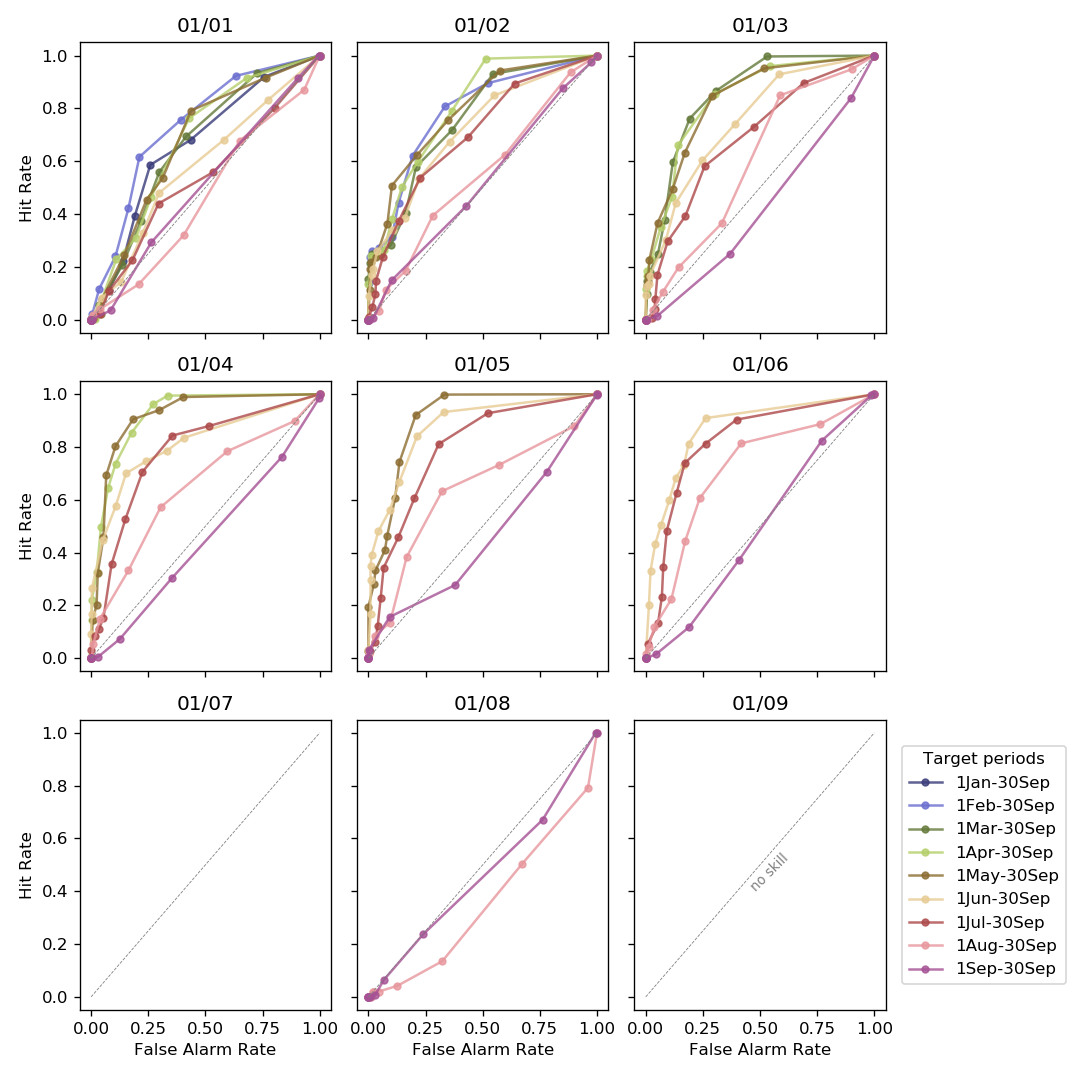

In [29]:
# Plot ROC curves for low flows

# Initialize some elements
fig, ax = plt.subplots(3,3,figsize=[9,9])
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = prob_verif_metrics_bs_basin_ds.target_period.values
init_dates = prob_verif_metrics_bs_basin_ds.init_date.values
elem_subplots = -1

# Loop over the initialization dates to plot
for i in init_dates:

    elem_subplots += 1
    elem_lines = -1
    
    far_toplot = roc_bs_da.sel(init_date=i, event=0.33, rate='FAR').mean(dim='iteration', skipna=False)
    hr_toplot = roc_bs_da.sel(init_date=i, event=0.33, rate='HR').mean(dim='iteration', skipna=False)
    for t in far_toplot.target_period.values:
        elem_lines += 1
        rgba = cmap((1*elem_lines)/len(target_periods))
        rgbas.append(rgba)
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].plot(far_toplot.sel(target_period=t), hr_toplot.sel(target_period=t), color=rgba, marker='o', alpha=.8, ms=4, label=t)
        
    # Add elements to the plot
    ax[int(np.floor(elem_subplots/3)),elem_subplots%3].plot([0,1], [0,1], color='grey', ls='--', lw=.5)
    ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_title(i)
    if int(np.floor(elem_subplots/3)) == 2:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_xlabel('False Alarm Rate')
    else:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_xticklabels([])
    if elem_subplots%3 == 0:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_ylabel('Hit Rate')
    else:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_yticklabels([])
    
plt.annotate('no skill', (.45,.4), color='grey', fontsize=8, rotation=45)
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.75,.5))
plt.tight_layout();

This plot displays ROC curves for 'low flows' (i.e., flows below the lower tercile of the observed climatology) for different target periods and initialization dates. The ROC measures the ability of the forecast to discriminate between events (i.e., observed 'low flows') and non-events. It can be used as an indicator of the hindcasts's 'potential usefulness' for decision-making. The ROC curve travels from the bottom left to top left of diagram, then across to top right of the diagram. A line close to the top left corner indicates high performance. Lines below the diagonal indicate no skill. For the Bow River at Banff, we can see that overall hindcasts for target periods 1Jan-30Sep to 1Jul-30Sep are potentially useful at predicting 'low flows', especially for hindcasts initialized on the 1st of April and 1st of May.

In [30]:
# Save the figure
fig.savefig(settings['plots_path']+"ROCcurves_lowflows_basin"+test_basin_id+".png", dpi=300)

In [31]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

<IPython.core.display.Javascript object>


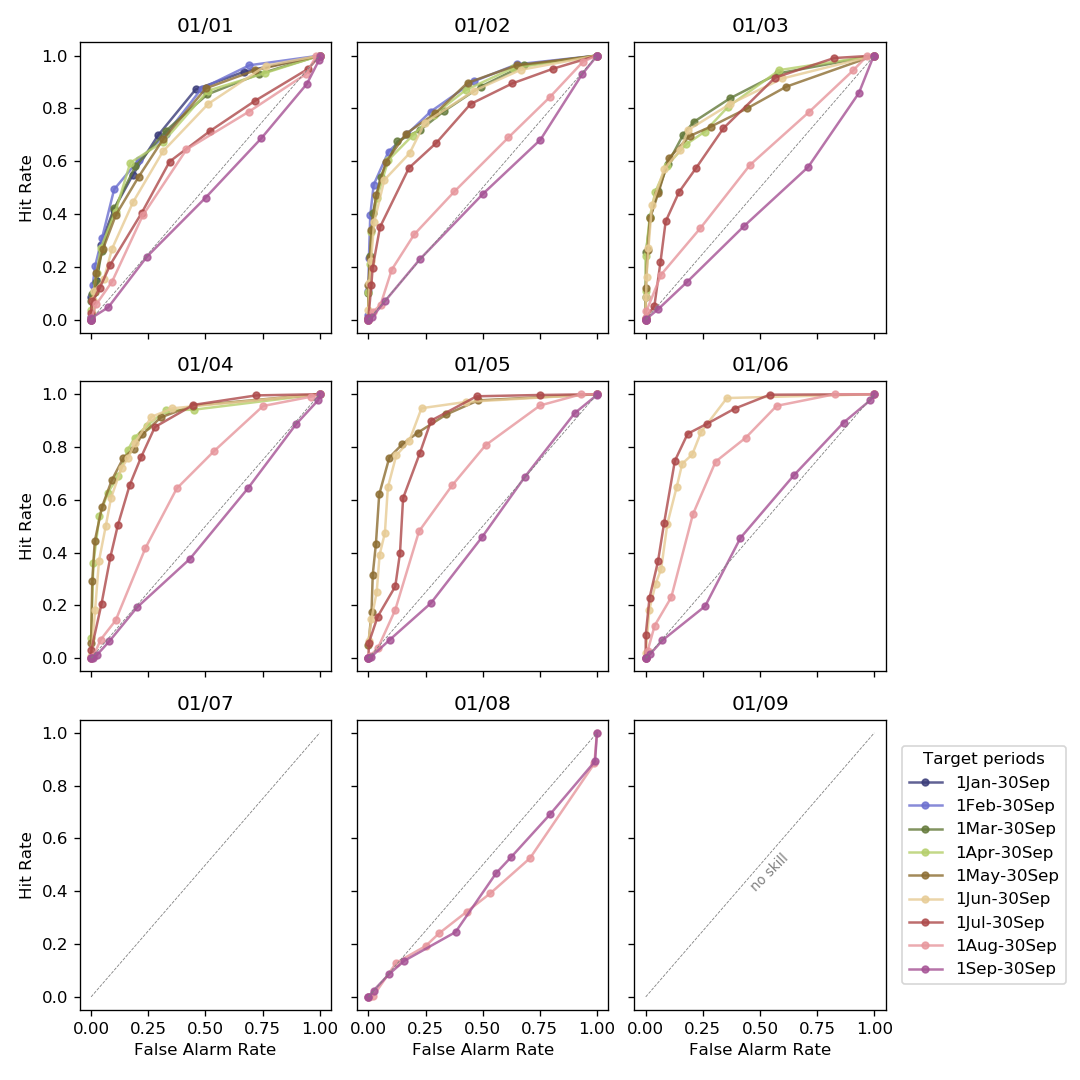

In [32]:
# Plot ROC curves for high flows

# Initialize some elements
fig, ax = plt.subplots(3,3,figsize=[9,9])
cmap = plt.cm.get_cmap('tab20b')
rgbas = []
target_periods = prob_verif_metrics_bs_basin_ds.target_period.values
init_dates = prob_verif_metrics_bs_basin_ds.init_date.values
elem_subplots = -1

# Loop over the initialization dates to plot
for i in init_dates:

    elem_subplots += 1
    elem_lines = -1
    
    far_toplot = roc_bs_da.sel(init_date=i, event=0.66, rate='FAR').mean(dim='iteration', skipna=False)
    hr_toplot = roc_bs_da.sel(init_date=i, event=0.66, rate='HR').mean(dim='iteration', skipna=False)
    for t in far_toplot.target_period.values:
        elem_lines += 1
        rgba = cmap((1*elem_lines)/len(target_periods))
        rgbas.append(rgba)
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].plot(far_toplot.sel(target_period=t), hr_toplot.sel(target_period=t), color=rgba, marker='o', alpha=.8, ms=4, label=t)
        
    # Add elements to the plot
    ax[int(np.floor(elem_subplots/3)),elem_subplots%3].plot([0,1], [0,1], color='grey', ls='--', lw=.5)
    ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_title(i)
    if int(np.floor(elem_subplots/3)) == 2:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_xlabel('False Alarm Rate')
    else:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_xticklabels([])
    if elem_subplots%3 == 0:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_ylabel('Hit Rate')
    else:
        ax[int(np.floor(elem_subplots/3)),elem_subplots%3].set_yticklabels([])

plt.annotate('no skill', (.45,.4), color='grey', fontsize=8, rotation=45)
plt.legend(title='Target periods', loc='center right', bbox_to_anchor=(1.75,.5))
plt.tight_layout();

This is the same plot as above but for 'high flows' (i.e., flows above the upper tercile of the observed climatology). For the Bow River at Banff, the results for 'high flows' are very similar to the results for 'low flows', with perhaps a slighlty higher performance for the winter initialization dates and a slightly lower performance for the spring initialization dates.

In [33]:
# Save the figure
fig.savefig(settings['plots_path']+"ROCcurves_highflows_basin"+test_basin_id+".png", dpi=300)

In [34]:
# Close the figure - please run this as it will ensure that we're not overloading the memory unnecessarily
plt.close(fig)

## Save data
Save the evaluation results.

In [35]:
# Save the data
det_verif_metrics_bs_basin_ds.to_netcdf(settings['output_data_path']+"deterministic_verification_basin_"+test_basin_id+".nc", mode='w', format="NETCDF4")
prob_verif_metrics_bs_basin_ds.to_netcdf(settings['output_data_path']+"probabilistic_verification_basin_"+test_basin_id+".nc", mode='w', format="NETCDF4")